In [1]:
# Read data
import pandas as pd
X = pd.read_csv("X_train.csv",sep=';',decimal=',') 
Y = pd.read_csv("Y_train.csv",sep=';',decimal=',')
X_test = pd.read_csv("X_test.csv",sep=';',decimal=',') 
Y_test = pd.read_csv("Y_test.csv",sep=';',decimal=',')

In [2]:
# Detect most corrupted data
is_NaN = X.isnull()
max_nans = is_NaN.sum(axis = 1).max()
print('Max relation of NaNs over all parameters per row: {}%'.format(round(max_nans/(len(X.columns)-2)*100, 2)))

is_NaN_sum = is_NaN.sum()
nans_over_rows = (is_NaN_sum/len(X)*100)>65

print('{} parameters have at least 65% of data as NaN'.format(sum(nans_over_rows)))

Max relation of NaNs over all parameters per row: 46.43%
16 parameters have at least 65% of data as NaN


In [3]:
# Delete columns that have too much NaN values 
# Comment 3 lines below to keep all columns
columns_before = X.columns
X = X.loc[:,is_NaN.mean() < .65]
X_test = X_test[X.columns]
print('{} columns were deleted.'.format(len(columns_before)-len(X.columns)))

# Extract only values from raw data
X_train_vals = X.iloc[:,2:]
Y_train_vals = Y.iloc[:,2]
X_test_vals = X_test.iloc[:,2:]

# Fill NaN values with mean of corresponding column 
X_train_vals.apply(lambda x: x.fillna(x.mean(),inplace=True),axis=0)
X_test_vals.apply(lambda x: x.fillna(x.mean(),inplace=True),axis=0)

# Delete rows where y values are NaN 
data = pd.concat([X_train_vals, Y_train_vals], axis=1, join='inner')
data.dropna(axis = 0, inplace = True)

X_train_vals = data.drop('y',axis=1)
Y_train_vals = data.iloc[:,-1]

print('{} rows were deleted.'.format(len(Y) - len(Y_train_vals)))

16 columns were deleted.
41 rows were deleted.


In [4]:
# In order to make all x values equally important we perform MinMax Scaller to scale data to bounds [0-1]
# Also we exclude nagtive values to have count data
from sklearn import preprocessing 
Standardisation = preprocessing.StandardScaler()
# X_train_vals = Standardisation.fit_transform(X_train_vals) 
X_train_vals = preprocessing.MinMaxScaler(feature_range =(0, 1)).fit_transform(X_train_vals)

array([[0.34587606, 0.50186759, 0.54319621, ..., 0.08115036, 0.02470658,
        0.14706694],
       [0.33781322, 0.50187421, 0.54232295, ..., 0.08148746, 0.01532618,
        0.12778382],
       [0.33781322, 0.50186759, 0.53718054, ..., 0.08110579, 0.01510274,
        0.14489101],
       ...,
       [0.33781322, 0.50186759, 0.53718054, ..., 0.0814171 , 0.01324473,
        0.12495927],
       [0.3520363 , 0.79673082, 0.53884416, ..., 0.08106519, 0.01378962,
        0.12512227],
       [0.33925462, 0.50186759, 0.53718054, ..., 0.0971078 , 0.01568219,
        0.13074059]])

In [5]:
import sklearn.metrics as metrics
import numpy as np

# Weighted mean absolute percent error calculation function
def wmape(y, y_predicted):
    y = y.reset_index(drop = True)
    diff = y - y_predicted
    summed_y = diff.sum()
    summed_predicted = sum(y)
    return abs(summed_y)/summed_predicted*100

def show_metrics(y, y_pred):
    mean_absolute_error=metrics.mean_absolute_error(y, y_pred) 
    mse=metrics.mean_squared_error(y, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y, y_pred)
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('WMAPE: ', round(wmape(y,y_pred),4))

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import linear_model
from sklearn import neighbors
from sklearn.model_selection import train_test_split

# We need test data with y values so we split train data
xtrain, xtest, ytrain, ytest = train_test_split(X_train_vals, Y_train_vals, test_size = 0.20)

# Prepare regression models that most likely perform good on a given dataset
models = []
models.append(MLPRegressor())
models.append(RandomForestRegressor(n_estimators=10))
models.append(neighbors.KNeighborsRegressor())
models.append(linear_model.LinearRegression())
models.append(linear_model.SGDRegressor())

In [7]:
# Run models
for m in models:
    m.fit(xtrain,ytrain)
    ypred = m.predict(xtest)
    print('Model - {}:'.format(type(m).__name__))
    show_metrics(ytest, ypred)
    print('----------------------------------------------------------')

D:\Soft\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model - MLPRegressor:
MAE:  1830.6319
MSE:  5083355.183
RMSE:  2254.6297
WMAPE:  0.3413
----------------------------------------------------------
Model - RandomForestRegressor:
MAE:  1786.5764
MSE:  4965461.6937
RMSE:  2228.3316
WMAPE:  0.3641
----------------------------------------------------------
Model - KNeighborsRegressor:
MAE:  1941.7711
MSE:  5925179.1223
RMSE:  2434.1691
WMAPE:  0.9533
----------------------------------------------------------
Model - LinearRegression:
MAE:  1830.4457
MSE:  5090333.0689
RMSE:  2256.1766
WMAPE:  0.1695
----------------------------------------------------------
Model - SGDRegressor:
MAE:  1815.2633
MSE:  5032437.8222
RMSE:  2243.3096
WMAPE:  1.6628
----------------------------------------------------------


In [8]:
# Among all the models with different parameters and testings RandomForestRegressor has shown best performance.
ytest = ytest.reset_index(drop = True)
pred = models[2].predict(xtest)
ytest = pd.DataFrame(ytest)

# Merge predicted values to actual
ytest['predicted'] = pd.DataFrame(pred)
ytest.describe()

,y,predicted
count,1680.000000,1680.000000
mean,3645.497202,3610.746213
std,2290.414197,1048.782035
min,0.000000,419.805937
25%,1874.521244,2876.240141
50%,3345.427733,3549.863850
75%,5035.883915,4288.771509
max,10000.000000,7888.081270


<ipython-input-9-52b5202a8ea6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ytest_plot['index'] = ytest_plot.index


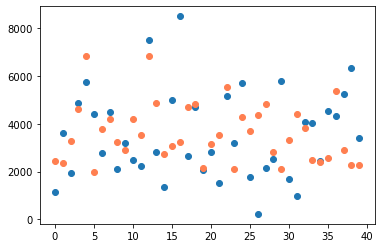

In [9]:
#Scattering y actual and predicted
import matplotlib.pyplot as plt
ytest_plot = ytest.head(40)
ytest_plot['index'] = ytest_plot.index

plt.scatter(ytest_plot.index, ytest_plot['y'])
plt.scatter(ytest_plot.index, ytest_plot['predicted'], c='coral' )

In [10]:
# Apply best model on test data.
y = models[2].predict(X_test_vals)

# Fill Y_test table with our predictions
Y_test['y'] = y

# Even though local accuracy is not the best. 
# Our main goal is to maximize Forecast Accuracy by minimizing WMAPE that was successfully done. 

In [16]:
Y_test.to_csv('Y_predicted.csv', index = False)